     exnode 8. movie text analysis
        1. library loding
        2. data loding
            1) data 전처리
        3. Embedding 레이어 : vector로 바꾼 결과
            1) text max len 
            2) text length same  > padding
            3) train , val data 생성 
        4. 모델링 .. 3번 기준           dropout
            1) RNN ........... 84.36     85.02
            2) CNN ........... 84.72     84.84
            3) MAX POOLING ... 82.44     84.56(epoch = 5)      
        5. word2vec
        6. 모델링... 5번 기준           dropout
            1) RNN   ......... 83.30     85.02
            2) CNN   ......... 84.78     84.89
            3) MAX POOLING ... 82.60     84.24(epoch = 10) 
        7. 비교 
           - 유사단어와 사전학습한 정확도가 비슷하게 도출되었으나 
             사전학습한 결과가 다소 유리하다고 판단됨.
           - 학습결과 정확도 85% 달성이 다소 힘들었슴 
             dropout을 이용하여 85% 달성
           - MAX POOLING으로 도출한 정확도가 다소 떨어짐 
           - 모델의 Parameter 활용 및 이 문제에 적합한 모델 선정을 좀 더 배워야 할 듯 합니다.

In [90]:
#1. library loding
import pandas
import konlpy
import gensim
import tensorflow as tf
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [91]:
#2. data loding
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [92]:
#2-1) 전처리
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [93]:
#2-1) 전처리 ... word_to_index 0-2 만듬  ... 새로 copy ----------------------------------------
word_to_index['<PAD>']=0 # 패딩용 단어
word_to_index['<BOS>']=1  # 문장의 시작지점
word_to_index['<UNK>']=2  # 사전에 없는(Unknown) 단어

In [94]:
#2-1) 전처리 ... index_to_word  ... 새로 copy ------------------------------------------------------------------
index_to_word = {index:word for word, index in word_to_index.items()}

In [95]:
#2-1) 전처리 ... index 만들고 1-3 
#index_to_word = {index:word for word, index in word_to_index.items()}
#index_to_word[0]='<PAD>'  # 패딩용 단어
#index_to_word[1]='<BOS>'  # 문장의 시작지점
#index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어

In [96]:
#2-1) 전처리 ... 변환 함수 
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [97]:
#2-1) 전처리  ... 0-3 처리 
#word_to_index={word:index-1 for index, word in index_to_word.items()}
#print(word_to_index)

In [98]:
#3-1) Embedding 레이어.. text max len 
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [99]:
#3-2) Embedding 레이어  ...padding
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(y_train.shape)

(146182, 41)
(146182,)


In [100]:
#3-3) Embedding 레이어 ... validation set creation
# validation set 30000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


In [101]:
#4-1) RNN 모델 구성 
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32, dropout=0.5))
#model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_68 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 9         
Total params: 328,593
Trainable params: 328,593
Non-trainable params: 0
_________________________________________________________________


In [102]:
#4-1) RNN Modeling ... Model training
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
114/114 [==============================] - 3s 11ms/step - loss: 0.6090 - accuracy: 0.6268 - val_loss: 0.4058 - val_accuracy: 0.8262
Epoch 2/20
114/114 [==============================] - 1s 7ms/step - loss: 0.3802 - accuracy: 0.8346 - val_loss: 0.3567 - val_accuracy: 0.8451
Epoch 3/20
114/114 [==============================] - 1s 7ms/step - loss: 0.3456 - accuracy: 0.8517 - val_loss: 0.3490 - val_accuracy: 0.8480
Epoch 4/20
114/114 [==============================] - 1s 7ms/step - loss: 0.3320 - accuracy: 0.8581 - val_loss: 0.3461 - val_accuracy: 0.8500
Epoch 5/20
114/114 [==============================] - 1s 7ms/step - loss: 0.3223 - accuracy: 0.8638 - val_loss: 0.3477 - val_accuracy: 0.8481
Epoch 6/20
114/114 [==============================] - 1s 7ms/step - loss: 0.3164 - accuracy: 0.8667 - val_loss: 0.3472 - val_accuracy: 0.8506
Epoch 7/20
114/114 [==============================] - 1s 7ms/step - loss: 0.3099 - accuracy: 0.8697 - val_loss: 0.3455 - val_accuracy: 0.8503
Epoch

In [103]:
#4-1) RNN Modeling  ... Model test data apply
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3669 - accuracy: 0.8502
[0.36690688133239746, 0.8501739501953125]


In [104]:
#4-1) RNN Modeling  ... Model graph  그려볼 수 있는 항목들
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


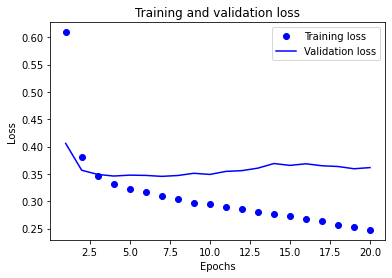

In [105]:
#4-1) RNN Modeling  ... Model graph  ...  loss graph 
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

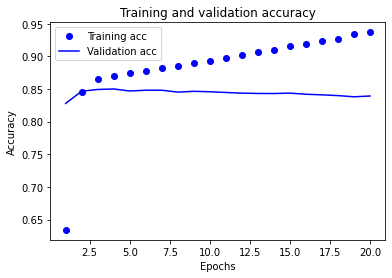

In [115]:
#4-1) RNN  Modeling  ... Model graph  ...  accuracy graph 
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [143]:
#4-2) cnn 모델 구성 
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import optimizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
        
vocab_size = 10000     # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 32   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
conv1d_76 (Conv1D)           (None, None, 32)          7200      
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
dropout_44 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, None, 64)          14400     
_________________________________________________________________
global_max_pooling1d_37 (Glo (None, 64)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 32)              

In [144]:
#4-2) cnn Modeling ... Model training 
              
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/20
114/114 [==============================] - 2s 7ms/step - loss: 0.6921 - accuracy: 0.5342 - val_loss: 0.6894 - val_accuracy: 0.6113
Epoch 2/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6781 - accuracy: 0.6474 - val_loss: 0.6566 - val_accuracy: 0.7120
Epoch 3/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6177 - accuracy: 0.7237 - val_loss: 0.5665 - val_accuracy: 0.7549
Epoch 4/20
114/114 [==============================] - 1s 6ms/step - loss: 0.5249 - accuracy: 0.7671 - val_loss: 0.4783 - val_accuracy: 0.7910
Epoch 5/20
114/114 [==============================] - 1s 6ms/step - loss: 0.4578 - accuracy: 0.7952 - val_loss: 0.4306 - val_accuracy: 0.8092
Epoch 6/20
114/114 [==============================] - 1s 6ms/step - loss: 0.4174 - accuracy: 0.8168 - val_loss: 0.3983 - val_accuracy: 0.8252
Epoch 7/20
114/114 [==============================] - 1s 6ms/step - loss: 0.3916 - accuracy: 0.8302 - val_loss: 0.3808 - val_accuracy: 0.8332
Epoch 

In [145]:
#4-2) cnn Modeling  ... Model test data apply
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3549 - accuracy: 0.8484
[0.3548949658870697, 0.8483837246894836]


In [203]:
#4-2) cnn Modeling  ... Model graph  그려볼 수 있는 항목들
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


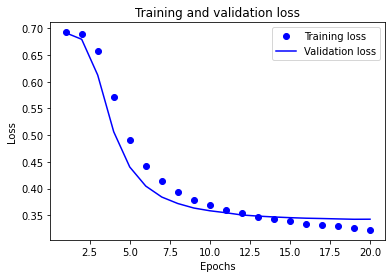

In [204]:
#4-2) cnn Modeling  ... Model graph  ...  loss graph 
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

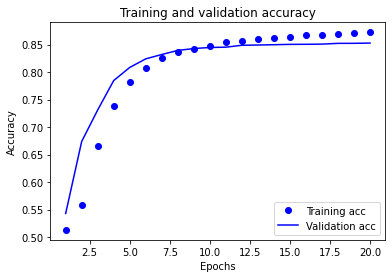

In [205]:
#4-2) cnn Modeling  ... Model graph  ...  accuracy graph 
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [159]:
#4-3) GlobalMaxPooling1D() 
ocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 32   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_62 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_43 (Glo (None, 32)                0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 33        
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_________________________________________________________________


In [160]:
#4-3) GlobalMaxPooling1D Modeling ... Model training
model.compile(optimizer='adam',               
              loss='binary_crossentropy',
              metrics=['accuracy'])


epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
114/114 [==============================] - 1s 5ms/step - loss: 0.6156 - accuracy: 0.7257 - val_loss: 0.4506 - val_accuracy: 0.8154
Epoch 2/5
114/114 [==============================] - 0s 4ms/step - loss: 0.3958 - accuracy: 0.8291 - val_loss: 0.3583 - val_accuracy: 0.8412
Epoch 3/5
114/114 [==============================] - 0s 4ms/step - loss: 0.3427 - accuracy: 0.8540 - val_loss: 0.3460 - val_accuracy: 0.8484
Epoch 4/5
114/114 [==============================] - 0s 4ms/step - loss: 0.3174 - accuracy: 0.8673 - val_loss: 0.3442 - val_accuracy: 0.8496
Epoch 5/5
114/114 [==============================] - 0s 4ms/step - loss: 0.3005 - accuracy: 0.8745 - val_loss: 0.3452 - val_accuracy: 0.8505


In [161]:
#4-3) GlobalMaxPooling1D Modeling  ... Model test data apply
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3548 - accuracy: 0.8456
[0.3547510504722595, 0.8455560803413391]


In [162]:
#4-3) GlobalMaxPooling1D Modeling  ... Model graph  그려볼 수 있는 항목들
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


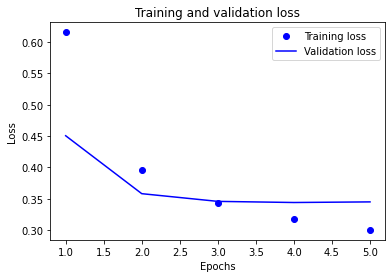

In [163]:
#4-3) GlobalMaxPooling1D Modeling  ... Model graph  ...  loss graph 
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

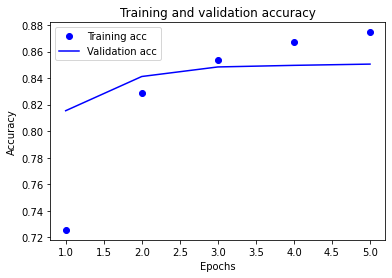

In [164]:
#4-3) GlobalMaxPooling1D Modeling  ... Model graph  ...  accuracy graph 
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [165]:
#5) word2vec  .. 단어사전
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['끝']

In [166]:
#5) word2vec ... 임베딩 레이어 변경
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]


In [185]:
#6) RNN 모델 구성 
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128, dropout=0.5))
model.add(Dropout(0.2))
#model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_68 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dropout_56 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 8)                 1032      
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 9         
Total params: 403,473
Trainable params: 403,473
Non-trainable params: 0
_________________________________________________________________


In [186]:
#6-1) RNN Modeling ... Model training
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
114/114 [==============================] - 4s 24ms/step - loss: 0.5584 - accuracy: 0.6714 - val_loss: 0.3814 - val_accuracy: 0.8296
Epoch 2/10
114/114 [==============================] - 2s 16ms/step - loss: 0.3764 - accuracy: 0.8357 - val_loss: 0.3630 - val_accuracy: 0.8412
Epoch 3/10
114/114 [==============================] - 2s 16ms/step - loss: 0.3478 - accuracy: 0.8509 - val_loss: 0.3499 - val_accuracy: 0.8498
Epoch 4/10
114/114 [==============================] - 2s 16ms/step - loss: 0.3305 - accuracy: 0.8596 - val_loss: 0.3473 - val_accuracy: 0.8484
Epoch 5/10
114/114 [==============================] - 2s 16ms/step - loss: 0.3192 - accuracy: 0.8641 - val_loss: 0.3464 - val_accuracy: 0.8509
Epoch 6/10
114/114 [==============================] - 2s 16ms/step - loss: 0.3092 - accuracy: 0.8690 - val_loss: 0.3499 - val_accuracy: 0.8489
Epoch 7/10
114/114 [==============================] - 2s 16ms/step - loss: 0.3023 - accuracy: 0.8724 - val_loss: 0.3505 - val_accuracy: 0.8526

In [187]:
#6-1) RNN Modeling  ... Model test data apply
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3498 - accuracy: 0.8502
[0.3498317301273346, 0.8501535654067993]


In [133]:
#6-1) RNN Modeling  ... Model graph  그려볼 수 있는 항목들
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


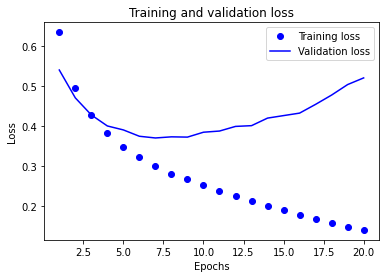

In [134]:
#6-1) RNN Modeling  ... Model graph  ...  loss graph 
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

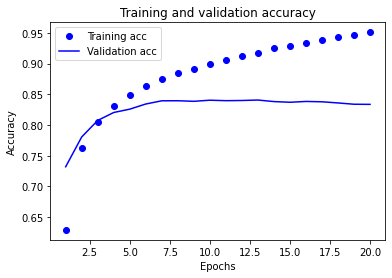

In [135]:
#6-1) RNN  Modeling  ... Model graph  ...  accuracy graph 
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [200]:
#6-2) cnn 모델 구성 
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import optimizers
        
vocab_size = 10000     # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 32   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(Dropout(0.4))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_73 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
conv1d_86 (Conv1D)           (None, None, 64)          14400     
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, None, 64)          0         
_________________________________________________________________
dropout_65 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
conv1d_87 (Conv1D)           (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d_48 (Glo (None, 64)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 32)              

In [201]:
#6-2) cnn Modeling ... Model training 
#model.compile(optimizer='adam',               
#              loss='binary_crossentropy',
#              metrics=['accuracy'])
              
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
114/114 [==============================] - 2s 9ms/step - loss: 0.6927 - accuracy: 0.5131 - val_loss: 0.6917 - val_accuracy: 0.5430
Epoch 2/20
114/114 [==============================] - 1s 7ms/step - loss: 0.6888 - accuracy: 0.5578 - val_loss: 0.6796 - val_accuracy: 0.6739
Epoch 3/20
114/114 [==============================] - 1s 7ms/step - loss: 0.6572 - accuracy: 0.6656 - val_loss: 0.6126 - val_accuracy: 0.7312
Epoch 4/20
114/114 [==============================] - 1s 7ms/step - loss: 0.5723 - accuracy: 0.7384 - val_loss: 0.5064 - val_accuracy: 0.7847
Epoch 5/20
114/114 [==============================] - 1s 7ms/step - loss: 0.4919 - accuracy: 0.7817 - val_loss: 0.4404 - val_accuracy: 0.8085
Epoch 6/20
114/114 [==============================] - 1s 7ms/step - loss: 0.4431 - accuracy: 0.8078 - val_loss: 0.4047 - val_accuracy: 0.8241
Epoch 7/20
114/114 [==============================] - 1s 7ms/step - loss: 0.4145 - accuracy: 0.8249 - val_loss: 0.3842 - val_accuracy: 0.8320
Epoch 

In [202]:
#6-2) cnn Modeling  ... Model test data apply
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3538 - accuracy: 0.8489
[0.3537951409816742, 0.8488516211509705]


In [206]:
#6-2) cnn Modeling  ... Model graph  그려볼 수 있는 항목들
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


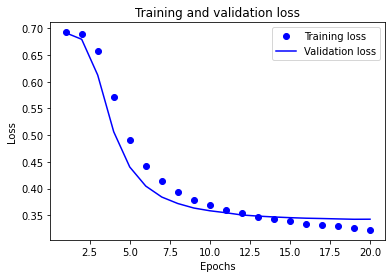

In [207]:
#6-2) cnn Modeling  ... Model graph  ...  loss graph 
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

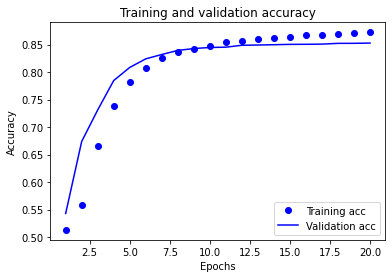

In [208]:
#6-2) cnn Modeling  ... Model graph  ...  accuracy graph 
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [212]:
#6-3) GlobalMaxPooling1D() 
ocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 32   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_75 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
global_max_pooling1d_50 (Glo (None, 32)                0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_140 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 9         
Total params: 320,273
Trainable params: 320,273
Non-trainable params: 0
_________________________________________________________________


In [213]:
#6-3) GlobalMaxPooling1D Modeling ... Model training
model.compile(optimizer='adam',               
              loss='binary_crossentropy',
              metrics=['accuracy'])


epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
114/114 [==============================] - 1s 5ms/step - loss: 0.6558 - accuracy: 0.6575 - val_loss: 0.5639 - val_accuracy: 0.8009
Epoch 2/10
114/114 [==============================] - 0s 4ms/step - loss: 0.4919 - accuracy: 0.7922 - val_loss: 0.3992 - val_accuracy: 0.8305
Epoch 3/10
114/114 [==============================] - 0s 4ms/step - loss: 0.4095 - accuracy: 0.8234 - val_loss: 0.3665 - val_accuracy: 0.8397
Epoch 4/10
114/114 [==============================] - 0s 4ms/step - loss: 0.3815 - accuracy: 0.8375 - val_loss: 0.3561 - val_accuracy: 0.8434
Epoch 5/10
114/114 [==============================] - 0s 4ms/step - loss: 0.3651 - accuracy: 0.8457 - val_loss: 0.3520 - val_accuracy: 0.8453
Epoch 6/10
114/114 [==============================] - 0s 4ms/step - loss: 0.3513 - accuracy: 0.8518 - val_loss: 0.3501 - val_accuracy: 0.8476
Epoch 7/10
114/114 [==============================] - 0s 4ms/step - loss: 0.3411 - accuracy: 0.8570 - val_loss: 0.3504 - val_accuracy: 0.8481
Epoch 

In [214]:
#6-3) GlobalMaxPooling1D Modeling  ... Model test data apply
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3628 - accuracy: 0.8424
[0.36277860403060913, 0.842443585395813]


In [215]:
#6-3) GlobalMaxPooling1D Modeling  ... Model graph  그려볼 수 있는 항목들
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


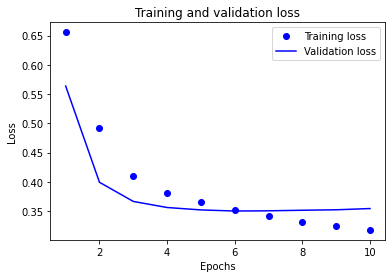

In [217]:
#6-3) GlobalMaxPooling1D Modeling  ... Model graph  ...  loss graph 
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

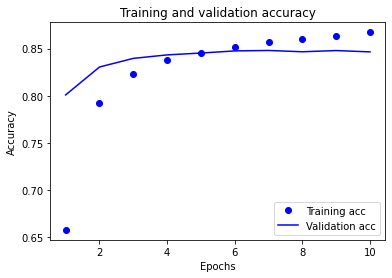

In [218]:
#6-3) GlobalMaxPooling1D Modeling  ... Model graph  ...  accuracy graph 
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()